In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gc_turbulence as g

%matplotlib inline

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1312: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

Below is the mean of the data in the front relative frame. At this point the data looks as we might expect.

<matplotlib.colorbar.Colorbar instance at 0x2ad740a58fc8>

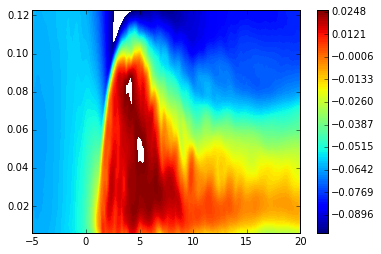

In [3]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)
plt.colorbar()

However if we consider a single data slice in the front relative frame we can see what appear to be background waves.

<matplotlib.colorbar.Colorbar instance at 0x2ad7463d3e60>

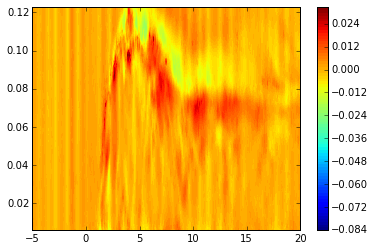

In [4]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)
plt.colorbar()

We don't see these waves in the front relative mean because they average out over the width of the observation window.

Here is a plot in the lab frame, from a single height.

<matplotlib.contour.QuadContourSet instance at 0x2ad746c054d0>

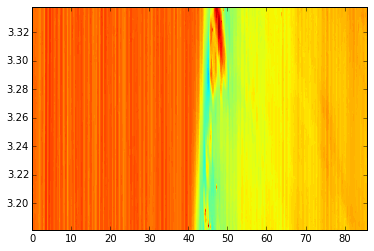

In [5]:
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]
plt.contourf(Te, r.X[0], mean_u, levels=u_levels)

We can see that the waves are very fast, compared to the front speed. Importantly, these waves don't appear to be causally related to the current.

A possible source of the waves is residual motion from filling the tank, but we will look at this more later.

We will treat them as background noise that needs to be removed. Leaving these waves in the data will cloud any frequency analysis that we wish to do.

Let's consider a timeseries from a single point in $(x, z)$.

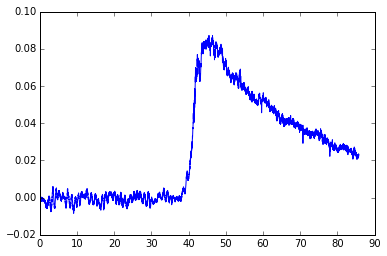

In [6]:
signal = r.U[10, 10, :]
plt.plot(r.T[10, 10, :], signal)

Now let's look at the portion before the front onset:

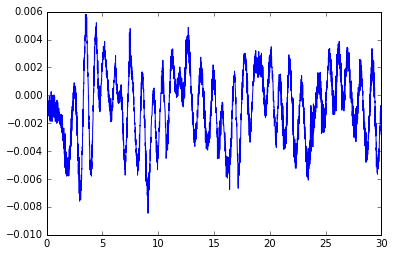

In [9]:
presignal = r.U[10, 10, :3000]
plt.plot(r.T[10, 10, :3000], presignal)

It appears that there are several wave frequencies represented here, as revealed by the frequency power spectrum:

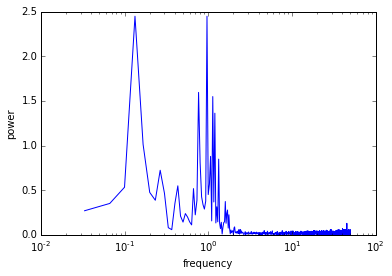

In [10]:
fft = np.fft.rfft(pre_signal)
freqs = np.fft.rfftfreq(pre_signal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))
plt.xlabel('frequency')
plt.ylabel('power')

There apears to be a harmonic series beginning at ~0.1Hz, along with a cluster of frequencies about 1Hz.

The cluster of frequencies is interesting. We can look at the wavelet transform to investigate this further.

In [11]:
import wavelets

wt = wavelets.WaveletTransform(presignal, dt=0.01)

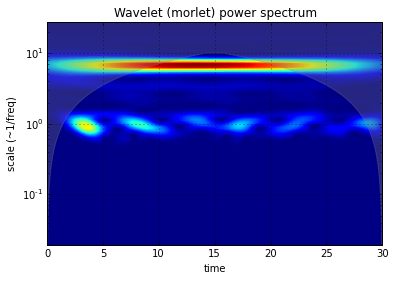

In [13]:
wt.plot_power()
plt.xlabel('time')
plt.ylabel('scale (~1/freq)')
plt.title('Wavelet (morlet) power spectrum')

The harmonic series has frequencies that are represented all through the timeseries, but the cluster is more complicated and has time dependent form.

**In particular, we cannot hope to recover the full wave signal simply by summing the peaks of the fourier transform.**

One feature of the waves is that they are symmetric across all x, z (or near enough, given how fast they are). This is not a property that is shared by the current.

If we can find a way to extract these symmetric features then we might be able to recover the wave signal.

A first guess would be to take the mean across x, z and hope that all other features cancel out leaving the wave signal.

This doesn't work. The data is dominated by the front:

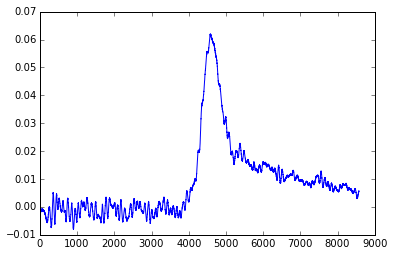

In [16]:
mean_signal = r.U[:].mean(axis=0).mean(axis=0)
plt.plot(mean_signal)

Applying a high pass filter in time may filter this out though. Let's filter out frequencies below 0.7Hz. It is somewhere lower than this that frequencies have wavelengths on the order of the observation window size, i.e. will likely not be averaged out.

<matplotlib.contour.QuadContourSet instance at 0x2ad75804ecf8>

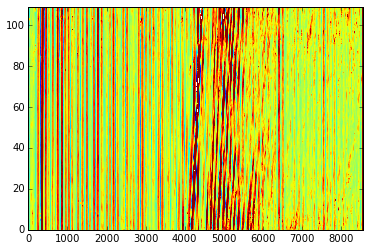

In [21]:
all_x_fft = np.fft.rfft(r.U[40, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)
power = np.abs(all_x_fft)

rfft = all_x_fft.copy()
rfft[:, all_freq < 0.7] = 0  
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)

If we now average in x, z (equivalent to applying a super low pass filter), we can recover part of the wave signal:

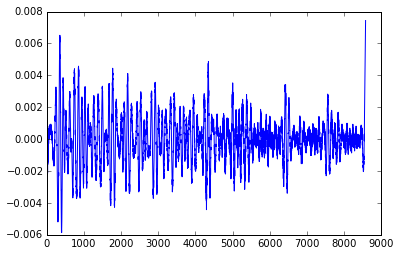

In [24]:
rsignal = rdata.mean(axis=0)
plt.plot(rsignal)

The wavelet transform of the recovered signal suggests that we have been successful:

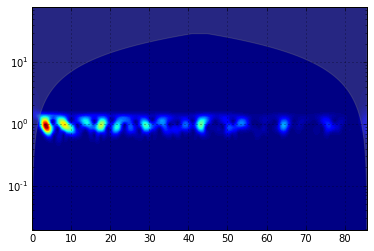

In [26]:
wavelets.WaveletTransform(rsignal, dt=0.01).plot_power()

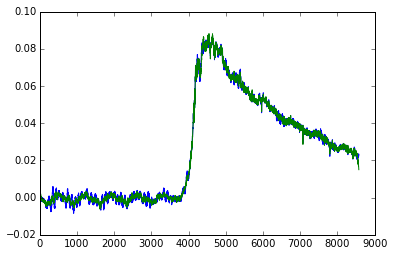

In [28]:
plt.plot(signal)
plt.plot(signal - rsignal)

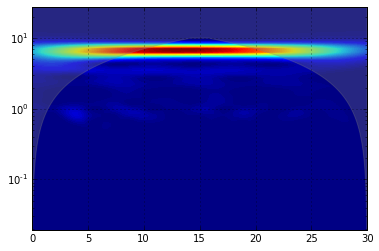

In [31]:
wavelets.WaveletTransform((signal - rsignal)[:3000], dt=0.01).plot_power()

We are left with the low frequency content that needs to be removed.